In [1]:

import gustaf as gus
import numpy as np
import vedo

vedo.settings.default_backend = "k3d"


import igl
import matplotlib.pyplot as plt
import splinepy as sp
import torch

import deep_sdf.utils
from deep_sdf import workspace as ws
from sdf_sampler.plotting import scatter_contour_at_z_level, scatter_contour_at_origin

params = {'text.usetex': False, 'mathtext.fontset': 'cm', 'axes.labelsize': 12}
plt.rcParams.update(params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

experiment_directory = "../../experiments/double_lattice_3D_no_topo"
checkpoint = "1000"

graded = True

latent = ws.load_latent_vectors(experiment_directory, checkpoint).to("cpu").numpy()
decoder = ws.load_trained_model(experiment_directory, checkpoint).to(device)
decoder.eval()
ws.print_model_specifications(experiment_directory=experiment_directory)

Model Specifications:
  Description: This experiment learns a shape representation for double lattice 3D, using the least possible number of parameters and thick struts, so hopefully no topological changes occur.
  DataSource: data
  NetworkArch: deep_sdf_decoder
  TrainSplit: data/splits/double_lattice_no_topo_3D.json
  TestSplit: data/splits/double_lattice_no_topo_3D.json
  ReconstructionSplit: 
  NetworkSpecs: {'dims': [32, 32, 32, 32], 'dropout': [0, 1, 2, 3, 4, 5, 6, 7], 'dropout_prob': 0.2, 'norm_layers': [0, 1, 2, 3, 4, 5, 6, 7], 'latent_in': [2], 'xyz_in_all': False, 'use_tanh': False, 'latent_dropout': False, 'weight_norm': True, 'geom_dimension': 3}
  CodeLength: 2
  NumEpochs: 1000
  SnapshotFrequency: 200
  AdditionalSnapshots: []
  LearningRateSchedule: [{'Type': 'Step', 'Initial': 0.0005, 'Interval': 500, 'Factor': 0.5}, {'Type': 'Step', 'Initial': 0.001, 'Interval': 500, 'Factor': 0.5}]
  SamplesPerScene: 16000
  ScenesPerBatch: 10
  DataLoaderThreads: 2
  ClampingDistan

In [2]:

u_min = -1
u_max = 1
v_min = -1
v_max = 1

spacing = 20
start_index = 211

control_points_graded = np.array([[u_min, v_min], [u_min, v_max], [u_max, v_min], [u_max, v_max]])
# control_points_graded = latent[start_index::spacing][:4]
control_points_ungraded = np.array([latent[60]]*6)

tiling = [8, 1, 8]
N_base = 30


control_points_for_min_max = np.vstack([control_points_graded, control_points_ungraded])

r_min = control_points_for_min_max[:,0].min()
r_max = control_points_for_min_max[:,0].max()
g_min = control_points_for_min_max[:,1].min()
g_max = control_points_for_min_max[:,1].max()


if graded:
    graded_string = "_graded"
    control_points = np.vstack([control_points_graded, control_points_graded])
else:
    graded_string = ""
    control_points = np.vstack([control_points_ungraded, control_points_ungraded])

latent_vec_interpolation = sp.BSpline(
    degrees=[1, 1, 1],
    knot_vectors=[[-1, -1, 1, 1],
                [-1, -1, 1, 1],
                [-1, -1, 1, 1]],
    control_points=control_points,
)

multi_index = sp.helpme.multi_index.MultiIndex(latent_vec_interpolation.control_mesh_resolutions)
minmin = np.array([u_min, v_min])
minmax = np.array([u_min, v_max])
maxmin = np.array([u_max, v_min])
maxmax = np.array([u_max, v_max])
latent_vec_interpolation.control_points[multi_index[0, 0, 0]] = minmin
latent_vec_interpolation.control_points[multi_index[0, 1, 0]] = minmin
latent_vec_interpolation.control_points[multi_index[1, 0, 0]] = maxmin
latent_vec_interpolation.control_points[multi_index[1, 1, 0]] = maxmin
latent_vec_interpolation.control_points[multi_index[0, 0, 1]] = minmax
latent_vec_interpolation.control_points[multi_index[0, 1, 1]] = minmax
latent_vec_interpolation.control_points[multi_index[1, 0, 1]] = maxmax
latent_vec_interpolation.control_points[multi_index[1, 1, 1]] = maxmax

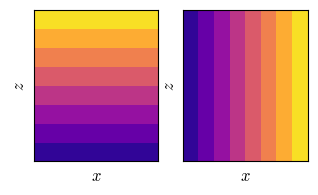

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(9/2.54, 5/2.54))
x = np.linspace(-1, 1, 1000)
z = np.linspace(-1, 1, 1000)
X, Z = np.meshgrid(x, z)


# Compute the z values for the grid
Y = latent_vec_interpolation.evaluate(np.hstack([X.reshape(-1,1), np.zeros_like(Z.reshape(-1,1)), Z.reshape(-1,1)]))
y_show = np.sqrt(Y[:,0]**2 + Y[:,1]**2).reshape(X.shape)
y_show = Y[:,1].reshape(X.shape)
axs[0].contourf(Z, X, Y[:,0].reshape(X.shape), cmap="plasma")
axs[1].contourf(Z, X, Y[:,1].reshape(X.shape), cmap="plasma")

r = Y[:,0].reshape(X.shape)
g = Y[:,1].reshape(X.shape)

r_norm = (r-r_min)/(r_max-r_min)
g_norm = (g-g_min)/(g_max-g_min)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$z$")
plt.savefig(f"screenshots/structure_latent{graded_string}.png", dpi=600, bbox_inches="tight")

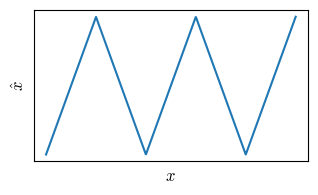

In [4]:

def transform(x, t):
    p = 2/t
    return (2/p)*torch.abs((x-t%2) % (p*2) - p) -1

def sdf_struct(queries):
    queries = torch.tensor(queries, dtype=torch.float32).to(device)
    tx, ty, tz = tiling


    samples = torch.zeros(queries.shape[0], 3)
    samples[:, 0] = transform(queries[:, 0], tx)
    samples[:, 1] = transform(queries[:, 1], ty)
    samples[:, 2] = transform(queries[:, 2], tz)
    lat_vec_red = torch.tensor(latent_vec_interpolation.evaluate(queries.cpu().numpy()), dtype=torch.float32)
    queries = torch.hstack([lat_vec_red.to(torch.float32).to(device), samples.to(device)])

    return deep_sdf.utils.decode_sdf(decoder, None, queries).squeeze(1).detach().cpu().numpy()


fig, ax = plt.subplots(1, 1, figsize=(9/2.54, 5/2.54))


x = torch.linspace(0, 1, 1000)
y = transform((x-0.5)*2, 5)
ax.plot(x.cpu().numpy(), y.cpu().numpy())
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\^x$")
ax.set_xticks([])
ax.set_yticks([])

plt.savefig(f"screenshots/structure_parameter_transform{graded_string}.png", dpi=600, bbox_inches="tight")

In [5]:
def generate_plane_points(origin, normal, num_points_u, num_points_v, spacing):
    """
    Generates evenly spaced points on a plane.
    
    Parameters:
    origin (array-like): A point on the plane (3D vector).
    normal (array-like): Normal vector of the plane (3D vector).
    num_points_u (int): Number of points along the first direction (u-axis).
    num_points_v (int): Number of points along the second direction (v-axis).
    spacing (float): Distance between adjacent points.
    
    Returns:
    points (numpy.ndarray): Array of points on the plane of shape (num_points_u * num_points_v, 3).
    """

    # Ensure the normal is a unit vector
    normal = np.array(normal)
    normal = normal / np.linalg.norm(normal)

    # Find two orthogonal vectors to the normal that lie on the plane (u and v axes)
    if np.allclose(normal, [0, 0, 1]):  # Special case when the normal is along z-axis
        u = np.array([1, 0, 0])
        v = np.array([0, 1, 0])
    else:
        u = np.cross([0, 0, 1], normal)  # Cross product to get a vector orthogonal to normal
        u = u / np.linalg.norm(u)        # Normalize the vector
        v = np.cross(normal, u)          # v is orthogonal to both normal and u

    # Create grid points in 2D space (u-v plane)
    u_coords = np.linspace(-num_points_u // 2, num_points_u // 2, num_points_u) * spacing
    v_coords = np.linspace(-num_points_v // 2, num_points_v // 2, num_points_v) * spacing
    
    points = []
    
    for u_val in u_coords:
        for v_val in v_coords:
            point = origin + u_val * u + v_val * v
            points.append(point)
    
    return np.array(points)

/home/michael.kofler/DeepSDF/sdf_sampler/plotting.py:92: UserWarning: The following kwargs were not used by contour: 'color'
  ax[0].contour(sdf, levels=[0], color="black", linewidths=0.5)


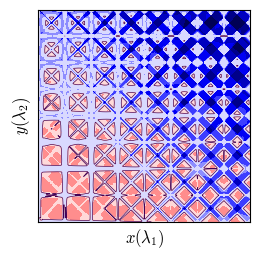

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7/2.54, 7/2.54))
scatter_contour_at_origin(sdf_struct, normal=(0,1,0), custom_axis=ax, res=1000)
ax.set_xlabel(r"$x (\lambda_1)$")
ax.set_ylabel(r"$y (\lambda_2)$")
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(f"screenshots/structure_sdf{graded_string}.png", dpi=600, bbox_inches="tight")

/home/michael.kofler/DeepSDF/sdf_sampler/plotting.py:36: UserWarning: The following kwargs were not used by contour: 'color'
  ax[0].contour(X*scale[0], Y*scale[1], sdf, levels=[0], color="black", linewidths=0.5)


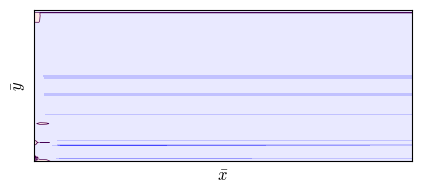

In [7]:

fig, ax = plt.subplots(1, 1, figsize=(5/2.54*10/4, 5/2.54))
scatter_contour_at_z_level(sdf_struct, custom_axis=ax, res=1000, flip_axes=True, eval_area=(-1,1), scale=(5,2))
ax.set_xlabel(r"$\bar{x}$")
ax.set_ylabel(r"$\bar{y}$")
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(f"screenshots/structure_sdf_scaled{graded_string}.png", dpi=600, bbox_inches="tight")


In [8]:

# mesh reconstruction

cap_border_dict = {
    "x0": {"cap": 1, "measure": 0.1},
    "x1": {"cap": 1, "measure": 0.1},
    "z0": {"cap": 1, "measure": 0.1},
    "z1": {"cap": 1, "measure": 0.1},
}

cap_border_dict = {}

N = [N_base * t+1 for t in tiling]

verts, faces, _ = deep_sdf.mesh.create_mesh_microstructure_diff(tiling, decoder, latent_vec_interpolation, N=N, max_batch=32 ** 3, offset=None, scale=None, cap_border_dict=cap_border_dict, device=None, output_tetmesh=False, compute_derivatives=True
)

# geometric parameters
width = 5
height = 5
depth = 1

# bring slightly outside vertices back
verts[verts>1] = 1
verts[verts<0] = 0

verts_FFD_transformed = verts.detach().cpu().numpy()
verts_FFD_transformed[:,0] = verts_FFD_transformed[:,0]*width
verts_FFD_transformed[:,1] = verts_FFD_transformed[:,1]*depth
verts_FFD_transformed[:,2] = verts_FFD_transformed[:,2]*height
surf_mesh = gus.faces.Faces(verts_FFD_transformed, faces.detach().cpu().numpy())
gus.show(surf_mesh, interactive=False, c="#EDEDED", lw=1)


K3DPlotterN(children=(Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680…

In [9]:

# t_in = tetgenpy.TetgenIO()
# t_in.setup_plc(dmesh.vertices, dmesh.faces.tolist())
# t_out = tetgenpy.tetrahedralize("pqa", t_in)

# showable = gus.show(*tiles, cam=cam, c="#EDEDED", interactive=False)
# print(showable)
# showable.screenshot("{this_folder}/training_tiles.png")

# fancy FFD
stop_here = True

if stop_here:
    cap_border_dict = {
        "y0": {"cap": -1, "measure": 0.1},
        "y1": {"cap": -1, "measure": 0.1},
    }


    # tiling = [2, 1, 5]
    # N_base = 50
    # N = [N_base * t+1 for t in tiling]

    verts, faces = deep_sdf.mesh.create_mesh_microstructure(tiling, decoder, latent_vec_interpolation, "none", cap_border_dict=cap_border_dict, N=N, use_flexicubes=False, device=device)
    # create spline
    spline_3d = sp.helpme.create.box(4.5, 2.5, 5.5)
    spline_3d.elevate_degrees([0, 1, 2])

    # manipulate cps
    # center cps
    cp_bounds = spline_3d.control_point_bounds
    spline_3d.control_points -= (cp_bounds[1] - cp_bounds[0]) / 2
    # use multi_index to get mid slice ids
    z_slice_ids = spline_3d.multi_index[:, :, 1]
    # rotate
    spline_3d.control_points[z_slice_ids] = gus.utils.arr.rotate(
        spline_3d.control_points[z_slice_ids], [0, 0, 79]
    )



    # bring slightly outside vertices back
    verts[verts>1] = 1
    verts[verts<0] = 0

    verts_FFD_transformed = spline_3d.evaluate(verts)

    surf_mesh = gus.faces.Faces(verts_FFD_transformed, faces)

    r = igl.decimate(surf_mesh.vertices, surf_mesh.faces, int(5e5))
    dmesh = gus.Faces(r[1], r[2])


    gus.show(dmesh, interactive=False, c="#EDEDED", lw=1)


/home/michael.kofler/DeepSDF/deep_sdf/mesh.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  queries = torch.hstack([torch.tensor(lat_vec_red).to(torch.float32), samples[:, 0:3]])


sampling takes: 0.519911


K3DPlotterN(children=(Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680…